In [1]:
import rioxarray as rx
import xarray as xr
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import joblib
import contextily as cx
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['figure.dpi'] = 200
plt.rcParams['font.family'] = ['Times New Roman + SimSun + Nowar Sans GB18030', ]  # 设置字体 simhei, Heiti TC
font_name = "Times New Roman + SimSun + Nowar Sans GB18030"

In [2]:
import geopandas as gpd
from rasterstats import zonal_stats
import rasterio
import northarrow_new
from scipy.stats import pearsonr

In [3]:
from inequality.schutz import Schutz
from inequality.gini import Gini
from inequality.theil import Theil

In [4]:
import os
os.chdir(r"/Volumes/2TMyRes/SynologyDrive/SCI/BeijingHeatExposure")

In [34]:
data = gpd.read_file('./EXPOSURE/final_many_idx.geojson')

In [35]:
data.head(1)

,net_id,Id,总人口,0-14,15-59,60以上,65以上,均价,建筑年代2,HSV,HSI,SHSR,MCHSD,CEHL,label,geometry
0,33,5ring,837.051829,100.615946,544.191633,190.950479,132.33866,31686.0,1994.0,0.476777,33.53758,0.979802,26.788571,44.139093,S,"POLYGON ((116.3724 39.76337, 116.37532 39.7633..."


In [36]:
len(data)

80493

In [37]:
data.columns

Index(['net_id', 'Id', '总人口', '0-14', '15-59', '60以上', '65以上', '均价', '建筑年代2',
       'HSV', 'HSI', 'SHSR', 'MCHSD', 'CEHL', 'label', 'geometry'],
      dtype='object')

In [38]:
ring2 = gpd.read_file('./边界数据/北京六环/二环.shp')
ring3 = gpd.read_file('./边界数据/北京六环/三环.shp')
ring4 = gpd.read_file('./边界数据/北京六环/四环.shp')
ring5 = gpd.read_file('./边界数据/北京六环/五环.shp')

ring2 = ring2.to_crs(4326)
ring3 = ring3.to_crs(4326)
ring4 = ring4.to_crs(4326)

region = './边界数据/研究区/五环.shp'
region = gpd.read_file(region)

In [39]:
region2 = gpd.read_file('./边界数据/研究区/五环_ns.shp')

In [40]:
region2

,label,geometry
0,S,"POLYGON ((116.20493 39.90586, 116.21222 39.906..."
1,N,"POLYGON ((116.53832 39.90879, 116.52233 39.908..."


# GINI

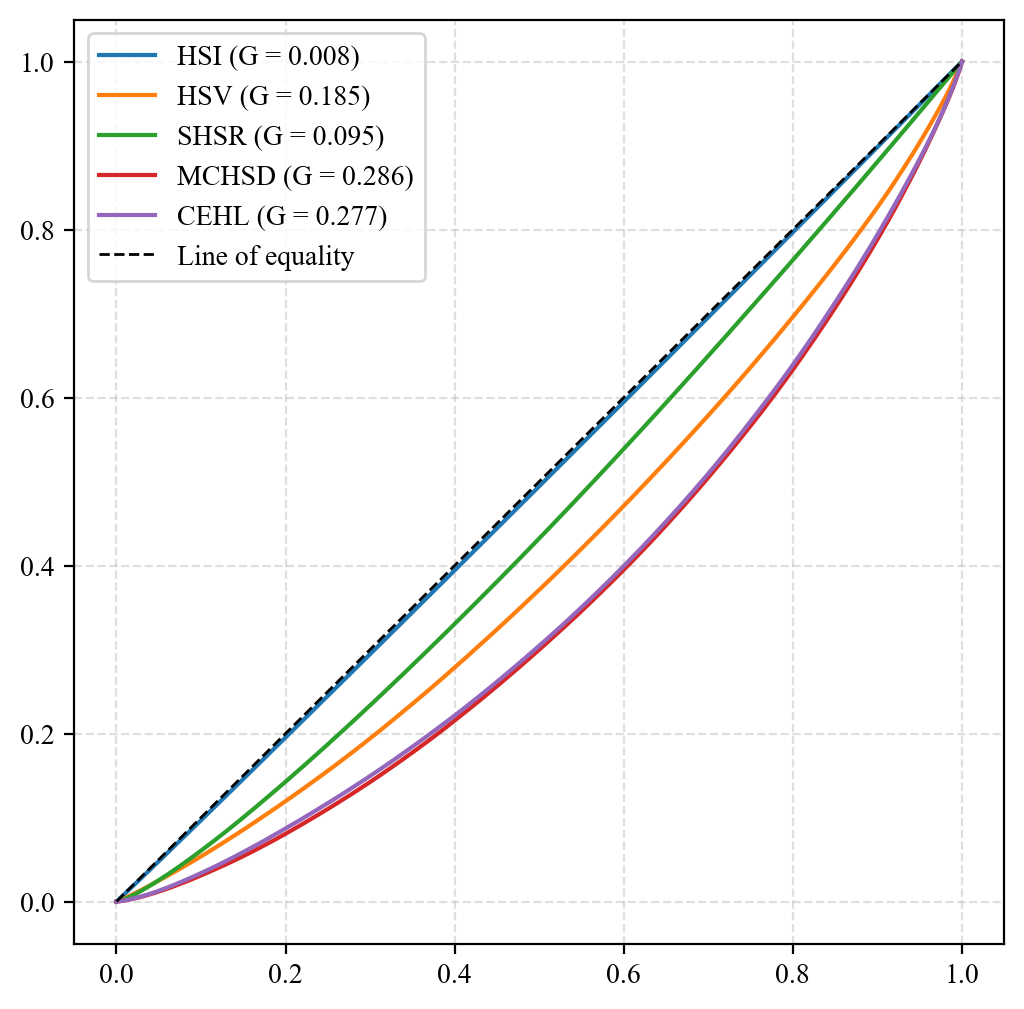

In [41]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_gini(array):
    """
    计算基尼系数
    :param array: 一个包含收入或财富的数组
    :return: 基尼系数
    """
    sorted_array = np.sort(array)
    n = len(array)
    cumulative_sum = np.cumsum(sorted_array, dtype=float)
    cumulative_share = cumulative_sum / cumulative_sum[-1]
    cumulative_population = np.linspace(1 / n, 1, n)
    B = np.trapezoid(cumulative_share, cumulative_population)
    A = 0.5 - B
    return A / 0.5

def plot_lorenz_curve(data, labels, gini_coefficients):
    """
    绘制洛伦兹曲线
    :param data: 包含不同组数据的列表
    :param labels: 各组的标签
    :param gini_coefficients: 各组的基尼系数
    """
    plt.figure(figsize=(6, 6))
    for i, array in enumerate(data):
        sorted_array = np.sort(array)
        n = len(array)
        cumulative_sum = np.cumsum(sorted_array, dtype=float)
        cumulative_share = cumulative_sum / cumulative_sum[-1]
        cumulative_population = np.linspace(0, 1, n)
        plt.plot(cumulative_population, cumulative_share, label=f'{labels[i]} (G = {gini_coefficients[i]:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Line of equality', lw=1)
    # plt.xlabel('Cumulative population (%)')
    # plt.ylabel('Cumulative accessibility (%)')
    # plt.title('Lorenz Curve')
    plt.legend()
    plt.grid(True, alpha=0.4, ls='--')
    plt.savefig(f'./SavedFig/04-gini.png', bbox_inches='tight',dpi=300)
    plt.show()


HSV, HSI, SHSR, MCHSD, CEHL = data['HSV'], data['HSI'], data['SHSR'], data['MCHSD'], data['CEHL']
# 计算基尼系数
gini_HSI = calculate_gini(HSI)
gini_HSV = calculate_gini(HSV)
gini_SHSR = calculate_gini(SHSR)
gini_MCHSD= calculate_gini(MCHSD)
gini_CEHL= calculate_gini(CEHL)

# 绘制洛伦兹曲线
plot_lorenz_curve([HSI, HSV, SHSR, MCHSD, CEHL], 
                  ['HSI', 'HSV', 'SHSR', 'MCHSD', 'CEHL'], 
                  [gini_HSI, gini_HSV, gini_SHSR, gini_MCHSD, gini_CEHL])

In [42]:
data.columns

Index(['net_id', 'Id', '总人口', '0-14', '15-59', '60以上', '65以上', '均价', '建筑年代2',
       'HSV', 'HSI', 'SHSR', 'MCHSD', 'CEHL', 'label', 'geometry'],
      dtype='object')

# correlation

In [43]:
data.head(1)

,net_id,Id,总人口,0-14,15-59,60以上,65以上,均价,建筑年代2,HSV,HSI,SHSR,MCHSD,CEHL,label,geometry
0,33,5ring,837.051829,100.615946,544.191633,190.950479,132.33866,31686.0,1994.0,0.476777,33.53758,0.979802,26.788571,44.139093,S,"POLYGON ((116.3724 39.76337, 116.37532 39.7633..."


In [44]:
data.rename(columns={'总人口':'Total population',
                    '60以上':'Age above 60',
                    '均价':'Average housing price',
                     '建筑年代2':'Average built year'             
                    },
            inplace=True
           
           )

In [45]:
data.columns

Index(['net_id', 'Id', 'Total population', '0-14', '15-59', 'Age above 60',
       '65以上', 'Average housing price', 'Average built year', 'HSV', 'HSI',
       'SHSR', 'MCHSD', 'CEHL', 'label', 'geometry'],
      dtype='object')

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [47]:
X = ['Total population','Age above 60', 'Average housing price', 'Average built year']
Y = ['HSI', 'HSV', 'SHSR', 'MCHSD', 'CEHL']

In [48]:
rdf = []
pdf = []
for y in Y:
    dic = {}
    
    rs = []
    ps = []
    for x in X:
        pearson_r, p_value_p = stats.pearsonr(data[x], data[y])
        rs.append(pearson_r)
        ps.append(p_value_p)
    dfr = pd.DataFrame({y : rs}).round(3)
    dfp = pd.DataFrame({y : ps}).round(3)
    print(dfr)
    rdf.append(dfr)
    pdf.append(dfp)

     HSI
0  0.170
1  0.209
2  0.037
3 -0.179
     HSV
0 -0.080
1 -0.082
2  0.079
3  0.008
    SHSR
0  0.156
1  0.183
2 -0.043
3 -0.129
   MCHSD
0  0.115
1  0.124
2 -0.115
3 -0.064
    CEHL
0  0.172
1  0.177
2 -0.094
3 -0.104


In [49]:
df1 = pd.concat(rdf, axis=1)

In [50]:
df1.index = X 

In [51]:
df1

,HSI,HSV,SHSR,MCHSD,CEHL
Total population,0.170,-0.080,0.156,0.115,0.172
Age above 60,0.209,-0.082,0.183,0.124,0.177
Average housing price,0.037,0.079,-0.043,-0.115,-0.094
Average built year,-0.179,0.008,-0.129,-0.064,-0.104


In [52]:
df1.to_excel('./Table/social inequity.xlsx')

In [53]:
p_value = pd.concat(pdf, axis=1)
p_value

,HSI,HSV,SHSR,MCHSD,CEHL
0,0.0,0.000,0.0,0.0,0.0
1,0.0,0.000,0.0,0.0,0.0
2,0.0,0.000,0.0,0.0,0.0
3,0.0,0.018,0.0,0.0,0.0


In [54]:
# 1. 定义转换函数
def get_significance_label(coef, p):
    if p < 0.001:
        return f"{coef:.3f}***"
    elif p < 0.01:
        return f"{coef:.3f}*"
    elif p < 0.05:
        return f"{coef:.3f}*"
    else:
        return f"{coef:.3f}"

In [55]:
# 2. 构造标签矩阵
annot_labels = []
rows, cols = df1.shape
for i in range(rows):
    row_labels = []
    for j in range(cols):
        coef = df1.iloc[i, j]
        p_val = p_value.iloc[i, j]
        row_labels.append(get_significance_label(coef, p_val))
    annot_labels.append(row_labels)

annot_labels = np.array(annot_labels)

In [56]:
annot_labels

array([['0.170***', '-0.080***', '0.156***', '0.115***', '0.172***'],
       ['0.209***', '-0.082***', '0.183***', '0.124***', '0.177***'],
       ['0.037***', '0.079***', '-0.043***', '-0.115***', '-0.094***'],
       ['-0.179***', '0.008*', '-0.129***', '-0.064***', '-0.104***']],
      dtype='<U9')

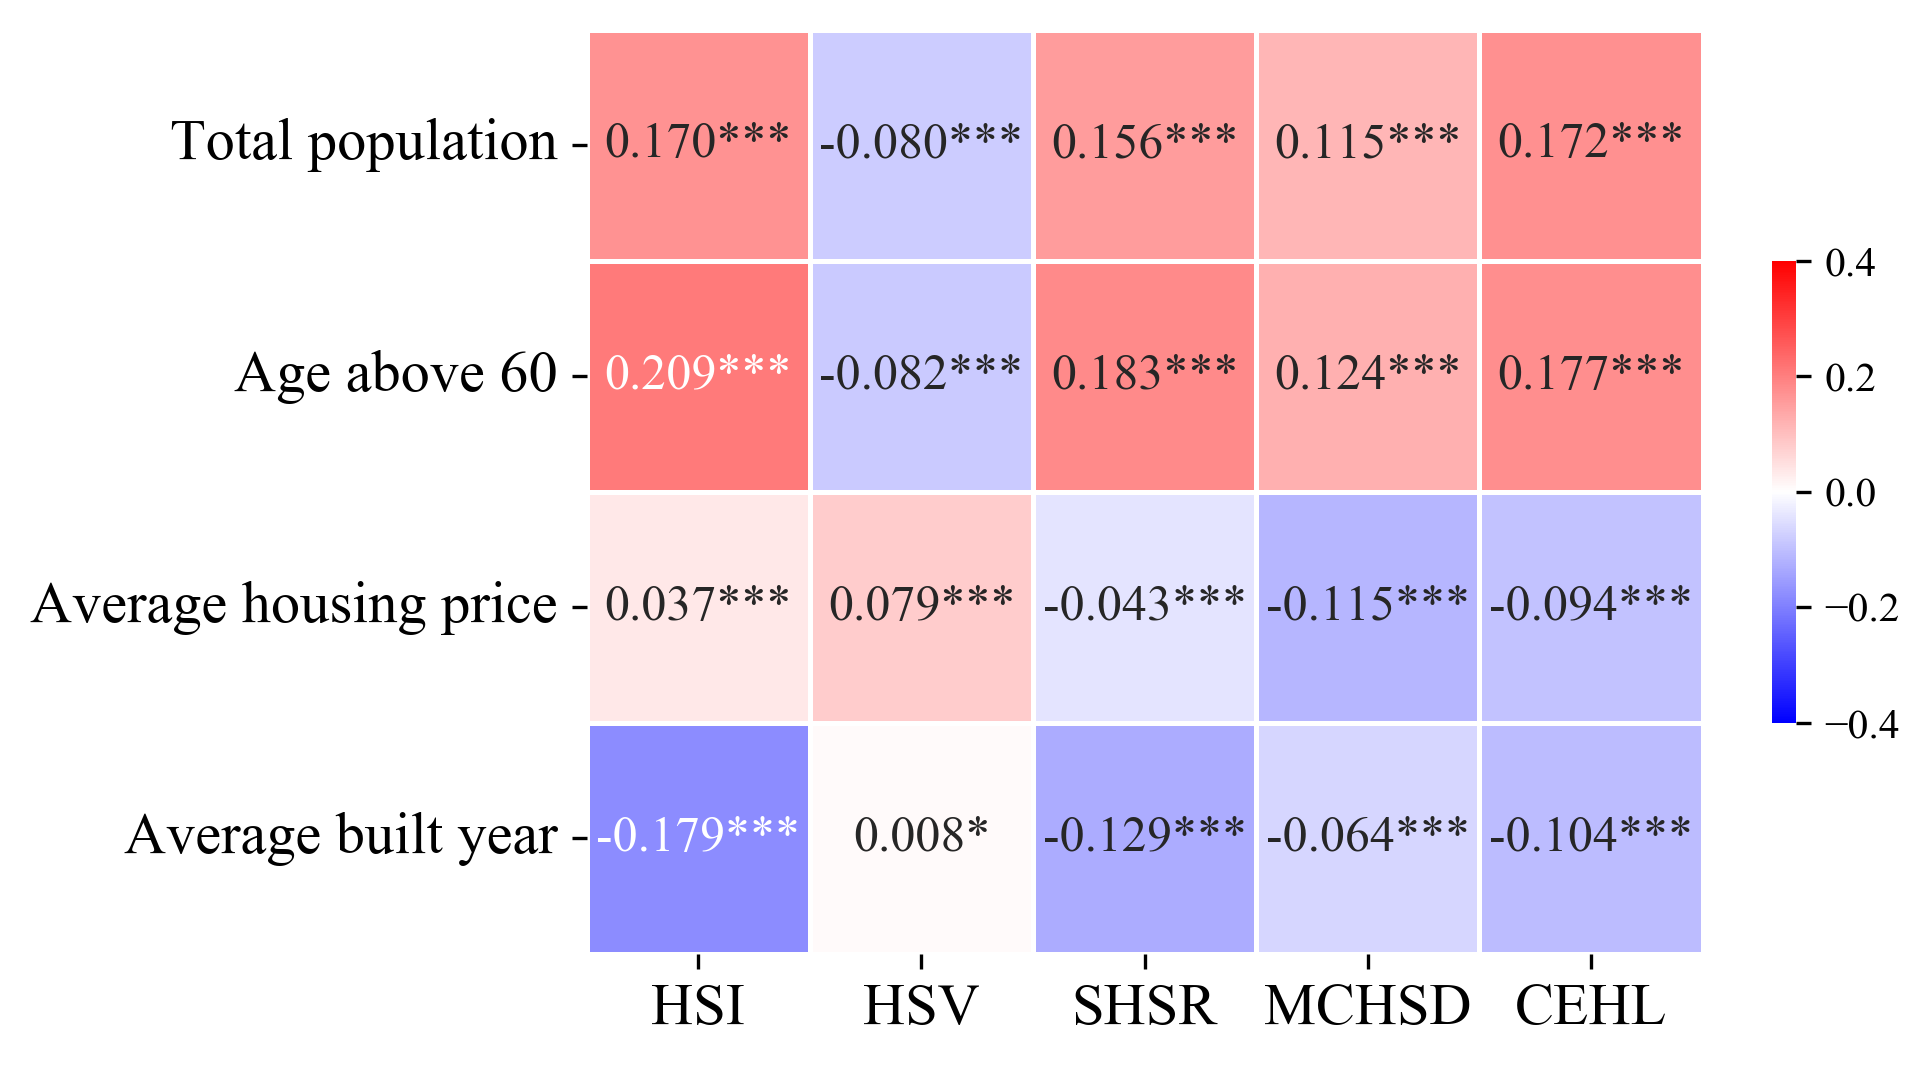

In [69]:
fig, ax = plt.subplots(figsize=(6,4),dpi=300)

sns.heatmap(data=df1, cmap='bwr',linewidths=.8,cbar_kws={"shrink": .5},
            annot=annot_labels, fmt='', center=0, vmin=-.4, vmax=.4,
            annot_kws={'size': 12, 'weight': 'bold',},
            ax=ax)

ax.tick_params(axis='both', which='major', labelsize=14)
plt.savefig(f'./SavedFig/05-correlation-all.png', bbox_inches='tight',dpi=300)


# rings

In [58]:
data.iloc[0]

net_id                                                                  33
Id                                                                   5ring
Total population                                                837.051829
0-14                                                            100.615946
15-59                                                           544.191633
Age above 60                                                    190.950479
65以上                                                             132.33866
Average housing price                                              31686.0
Average built year                                                  1994.0
HSV                                                               0.476777
HSI                                                               33.53758
SHSR                                                              0.979802
MCHSD                                                            26.788571
CEHL                     

In [67]:
def get_res(data, label='2ring'):
    X = ['Total population','Age above 60', 'Average housing price', 'Average built year']
    Y = ['HSI', 'HSV', 'SHSR', 'MCHSD', 'CEHL']
    data = data[data['Id'] == label]
    rdf = []
    pdf = []
    for y in Y:
        dic = {}
        
        rs = []
        ps = []
        for x in X:
            pearson_r, p_value_p = stats.pearsonr(data[x], data[y])
            rs.append(pearson_r)
            ps.append(p_value_p)
        dfr = pd.DataFrame({y: rs}).round(3)
        dfp = pd.DataFrame({y: ps}).round(3)
        # print(dfr)
        rdf.append(dfr)
        pdf.append(dfp)

    df1 = pd.concat(rdf, axis=1)
    df1.index = X
    df1.to_excel(f'./Table/social inequity {label}.xlsx')
    print('---'*20)
    print(f"****{label}****")
    px = pd.concat(pdf, axis=1)
    # 2. 构造标签矩阵
    annot_labels = []
    rows, cols = df1.shape
    for i in range(rows):
        row_labels = []
        for j in range(cols):
            coef = df1.iloc[i, j]
            p_val = p_value.iloc[i, j]
            row_labels.append(get_significance_label(coef, p_val))
        annot_labels.append(row_labels)
    
    annot_labels = np.array(annot_labels)

    print(annot_labels)
    
    fig, ax = plt.subplots(figsize=(6,4),dpi=300)

    sns.heatmap(data=df1, cmap='bwr',linewidths=.8,cbar_kws={"shrink": .5}, vmin=-.4, vmax=.4,
                annot=annot_labels, fmt='', center=0,
                annot_kws={'size': 12, 'weight': 'bold',},
                ax=ax)
    
    ax.tick_params(axis='both', which='major', labelsize=14) 
    plt.savefig(f'./SavedFig/05-correlation-{label}.png', bbox_inches='tight',dpi=300)


------------------------------------------------------------
****2ring****
[['0.108***' '0.030***' '0.078***' '0.106***' '0.119***']
 ['0.098***' '0.054***' '0.058***' '0.102***' '0.112***']
 ['0.089***' '-0.031***' '0.100***' '0.112***' '0.115***']
 ['-0.168***' '0.072*' '-0.137***' '-0.167***' '-0.218***']]
------------------------------------------------------------
****3ring****
[['0.097***' '-0.083***' '0.088***' '0.010***' '0.074***']
 ['0.109***' '-0.091***' '0.110***' '-0.018***' '0.015***']
 ['-0.110***' '0.111***' '-0.188***' '-0.222***' '-0.194***']
 ['-0.014***' '-0.044*' '0.030***' '-0.001***' '-0.052***']]
------------------------------------------------------------
****4ring****
[['0.231***' '-0.176***' '0.218***' '0.103***' '0.199***']
 ['0.217***' '-0.164***' '0.203***' '0.141***' '0.244***']
 ['-0.434***' '0.338***' '-0.441***' '-0.431***' '-0.391***']
 ['0.070***' '-0.214*' '0.074***' '0.081***' '-0.002***']]
----------------------------------------------------------

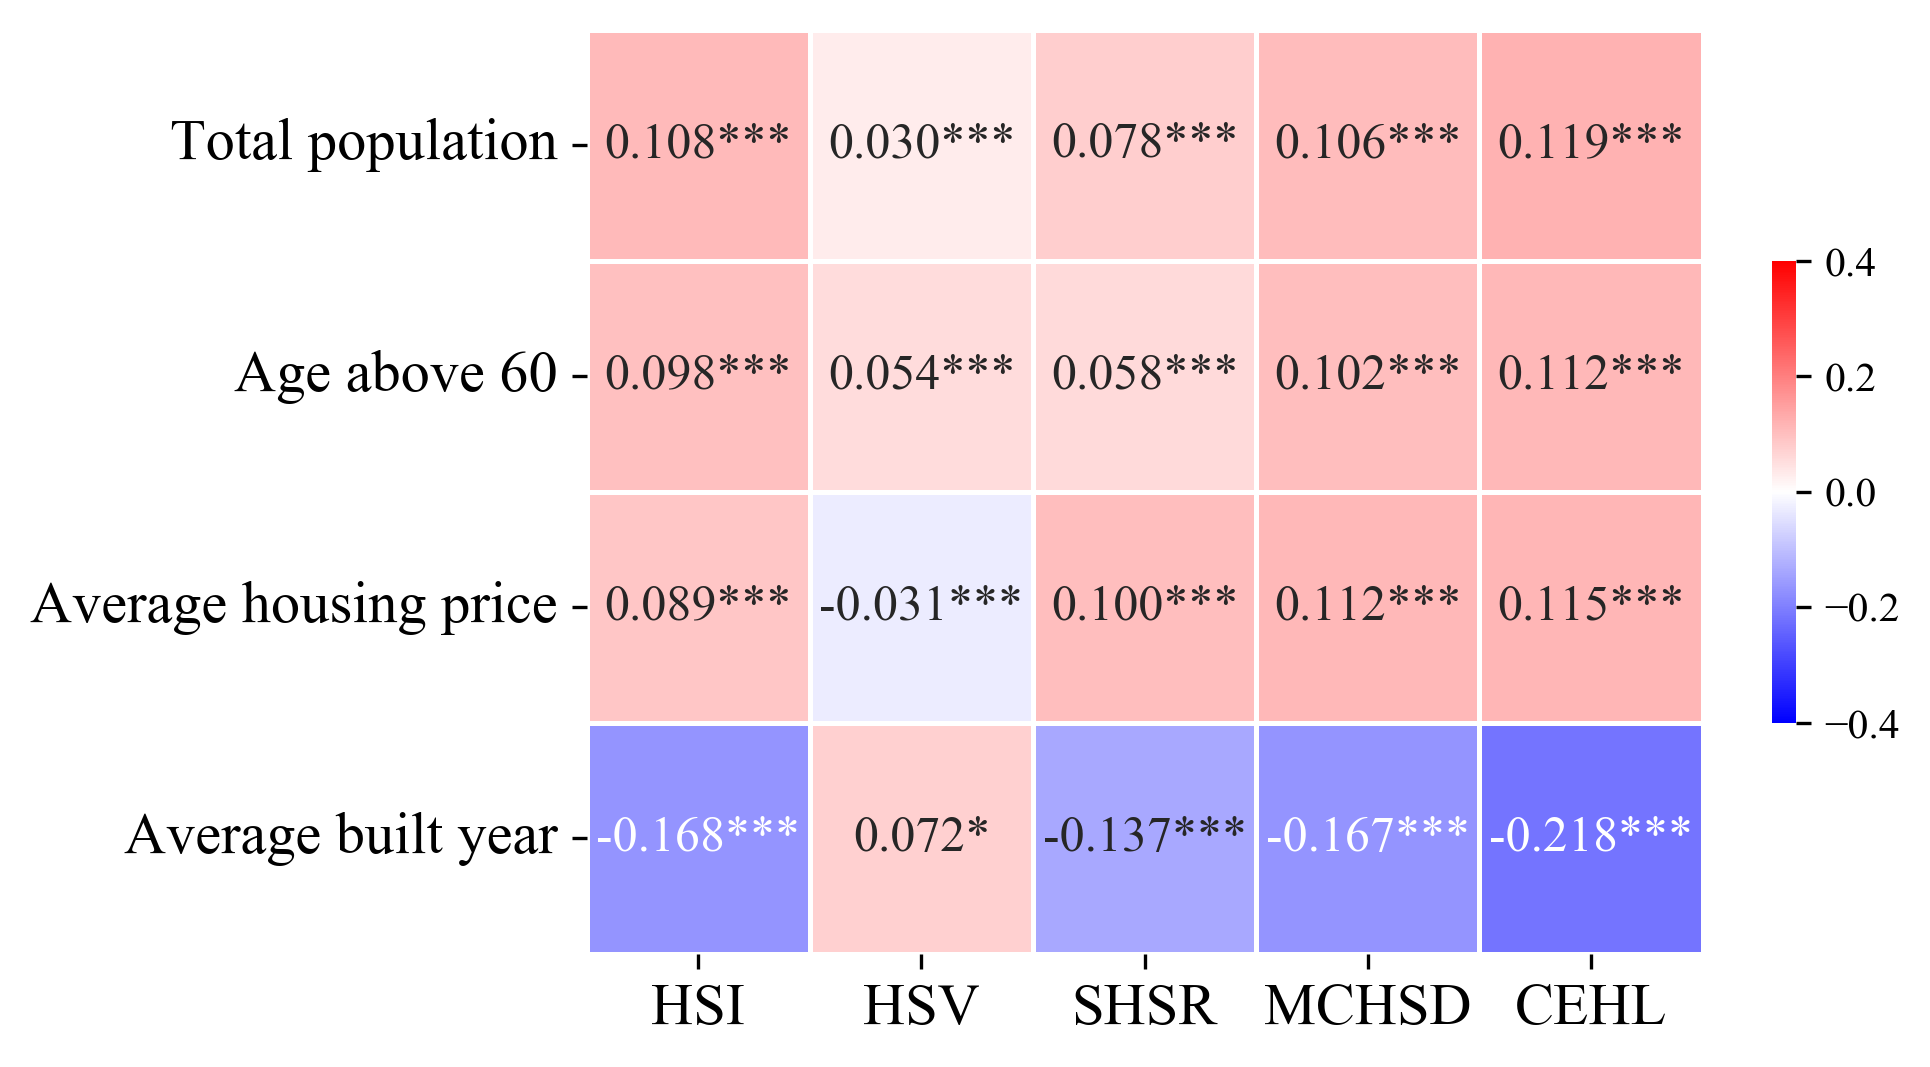

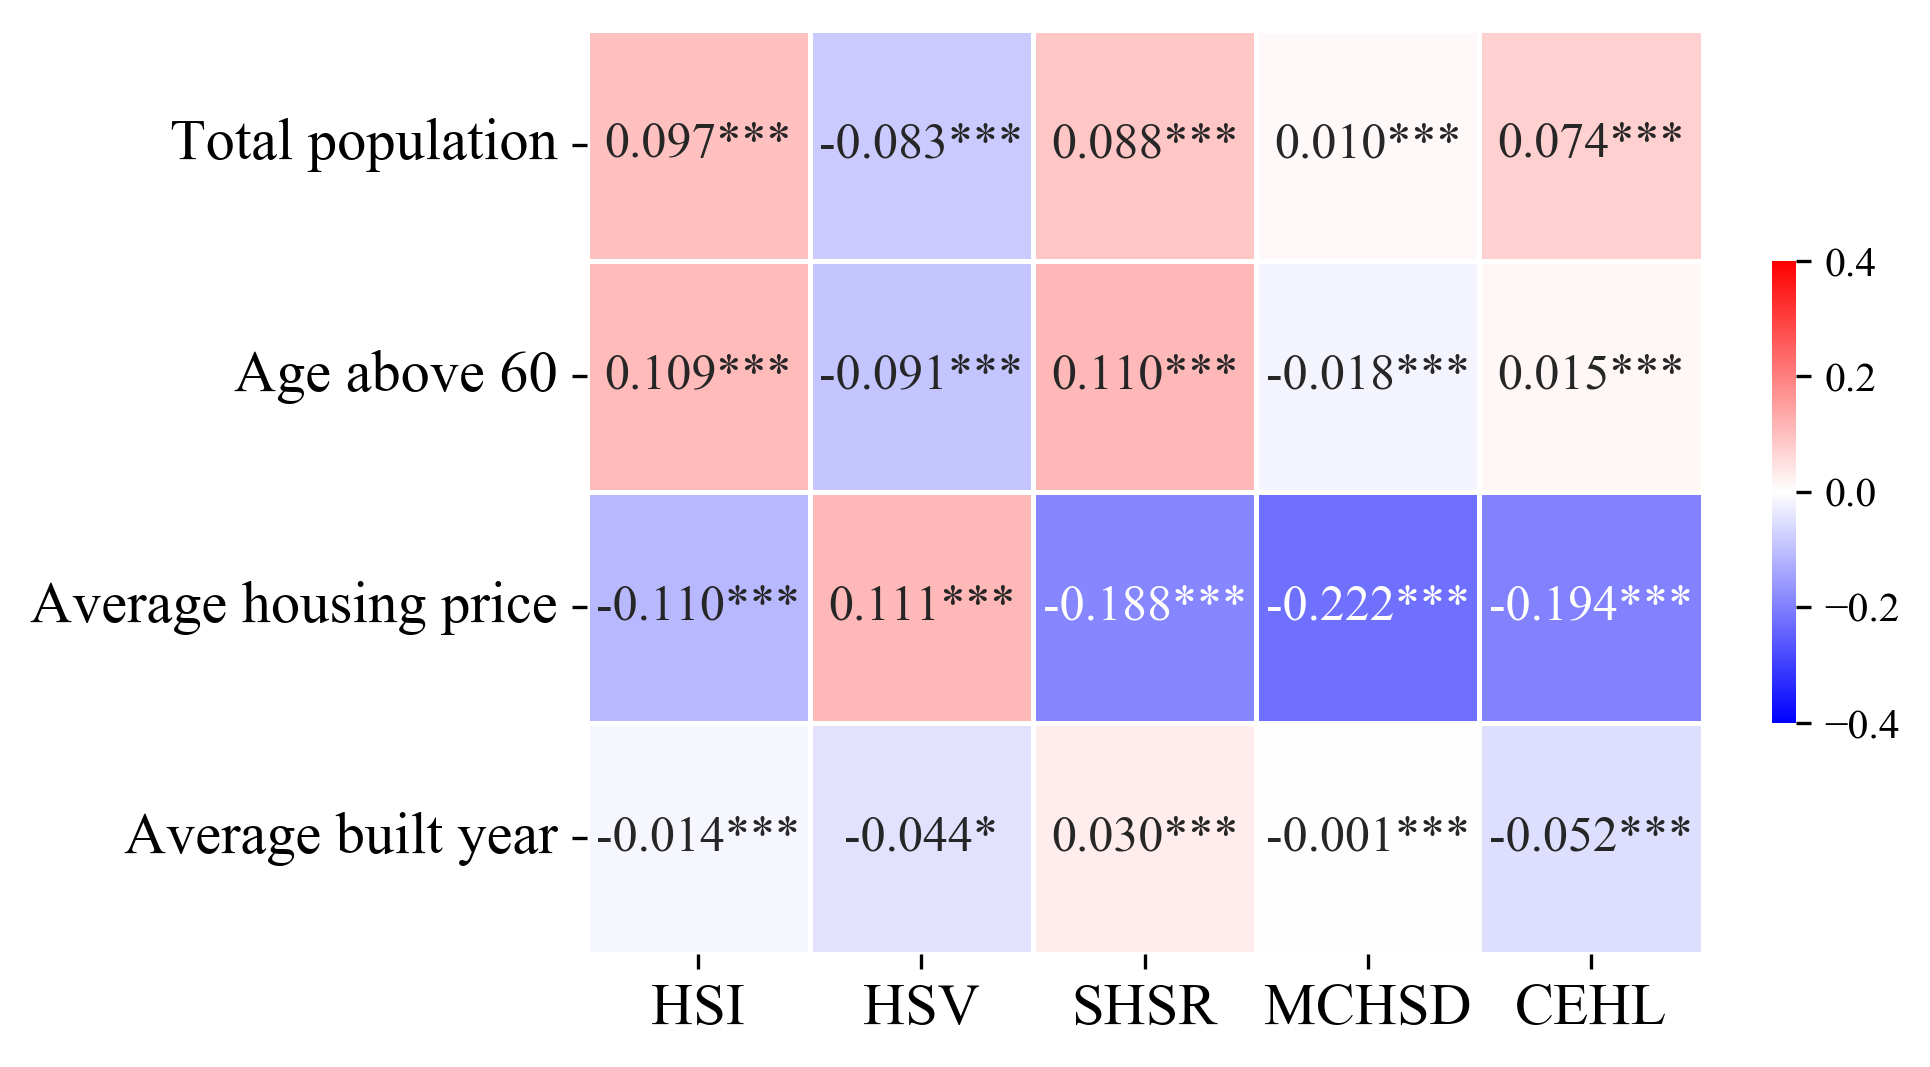

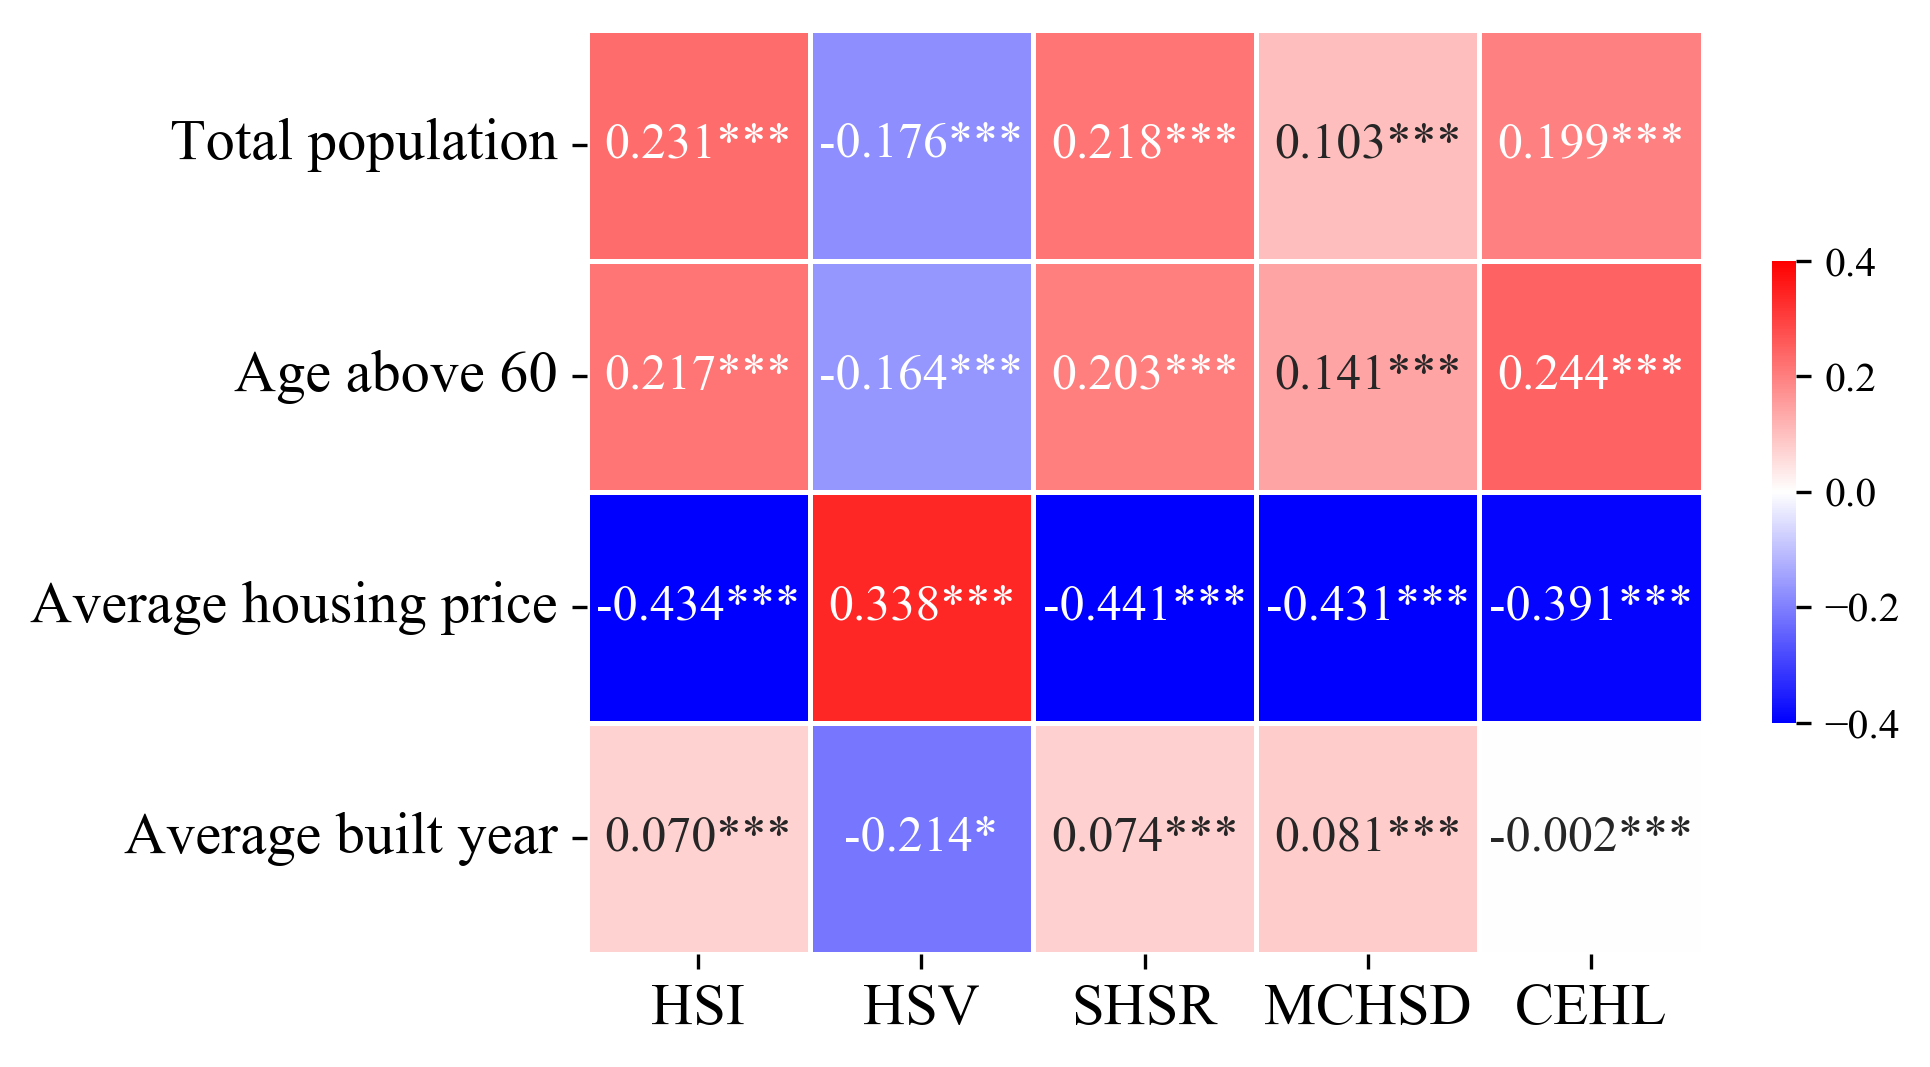

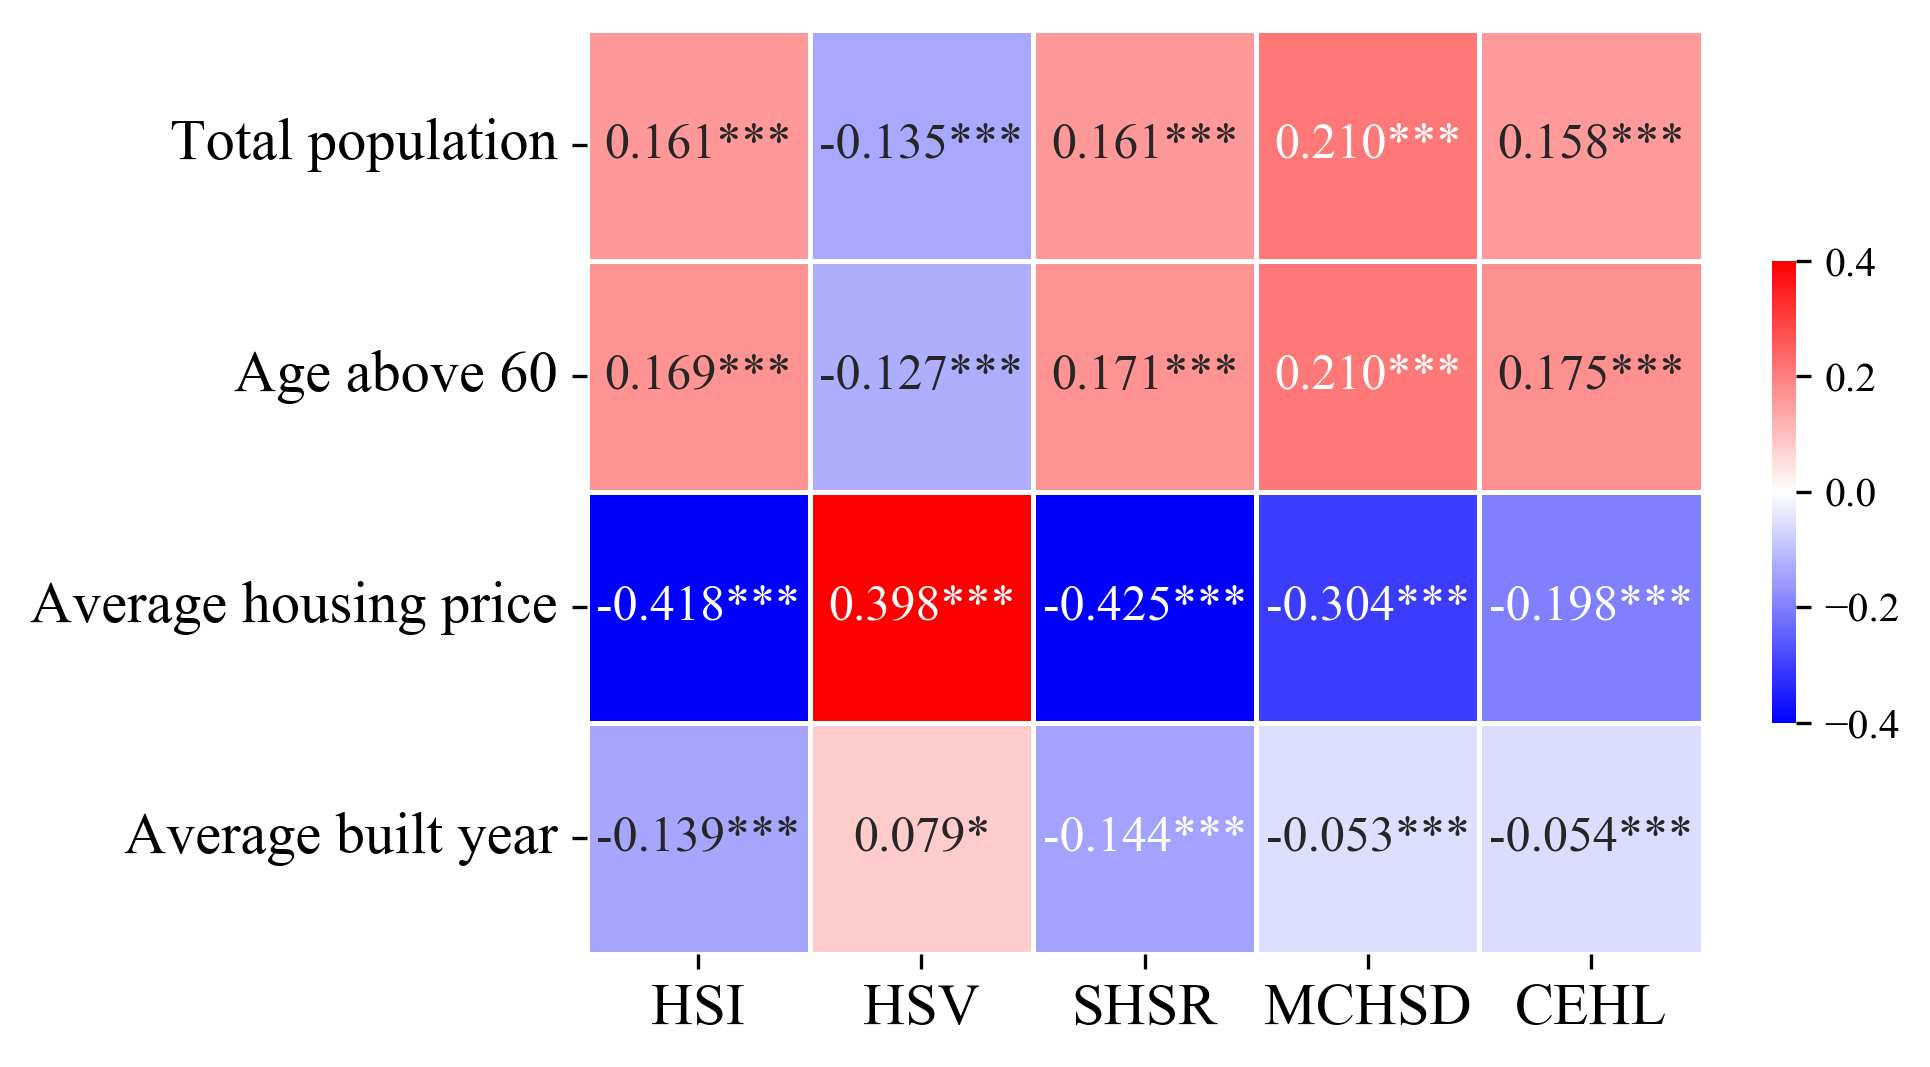

In [68]:
r2 = get_res(data, label='2ring')
r3 = get_res(data, label='3ring')
r4 = get_res(data, label='4ring')
r5 = get_res(data, label='5ring')